# Covariance of Early vs. Late Learning

The following code tries to show recurrent activity covariance doesn't change much before and after learning an new decoder

October 8, 2022

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# analysis
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.linear_model import LinearRegression
from scipy import stats, interpolate
from scipy import linalg as LA
from scipy.ndimage.filters import uniform_filter1d
from scipy.stats import pearsonr

# miscellaneous
from tqdm import tqdm
from itertools import cycle
from copy import deepcopy

import logging
import warnings
import dataclasses
from dataclasses import dataclass
from typing import Optional, List

import sys
sys.path.append("../..")

In [2]:
from rnn import RNNparams, RNN
from task import Task
from simulation import Simulation
from algorithms.bptt import BPTT
from algorithms.rflo import RFLO
from algorithms.reinforce import REINFORCE
from algorithms.track_vars import TrackVars

from utils.plotting import plot_trained_trajectories, paper_format, interp_colors
from utils.metric import cos_sim, return_norm_and_angle
from utils.functions import choose_aligned_matrix

from utils.metric import cos_sim, flow_field_data, flow_field_predicted, calculate_flow_field_correlation


### Train RNN on four targets

In [3]:
trial_duration = 20
n_in=4
frac_on = 0.2

x_tonic = 0.0*np.ones((trial_duration, n_in)) # shape 20 x 4 i.e. time x channel
x_pulse1 = x_tonic.copy()
x_pulse2 = x_tonic.copy()
x_pulse3 = x_tonic.copy()
x_pulse4 = x_tonic.copy()
x_pulse1[0:int(trial_duration*frac_on),0] = 1
x_pulse2[0:int(trial_duration*frac_on),1] = 1
x_pulse3[0:int(trial_duration*frac_on),2] = 1
x_pulse4[0:int(trial_duration*frac_on),3] = 1

task1 = Task(x_in=x_pulse1,y_target=np.asarray([[1],[1]]))
task2 = Task(x_in=x_pulse2,y_target=np.asarray([[-1],[1]]))
task3 = Task(x_in=x_pulse3,y_target=np.asarray([[1],[-1]]))
task4 = Task(x_in=x_pulse4,y_target=np.asarray([[-1],[-1]]))

In [4]:
folder = 'figs-2022-10-11/'

2it [00:00, 19.00it/s]

n_in: 4
n_rec: 50
n_out: 2
sig_in: 0.0
sig_rec: 0.25
sig_out: 0.01
tau_rec: 10
dt: 1.0
eta_in: 0.1
eta_rec: 0.1
eta_out: 0.1
g_in: 2.0
g_rec: 1.5
g_out: 2.0
g_fb: 2.0
driving_feedback: False
eta_fb: None
sig_fb: None
feedback_signal: position
velocity_transform: False
tau_vel: 0.8
dt_vel: 0.1
sig_rec_dim: None
eta_m: None
sig_m: None
lam_m: None
rng: <mtrand.RandomState object at 0x7fca37f292d0>


2500it [00:25, 99.44it/s]


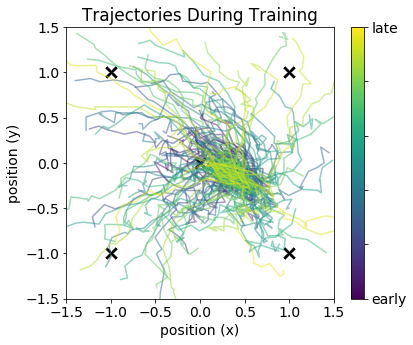

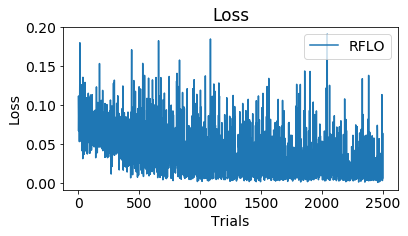

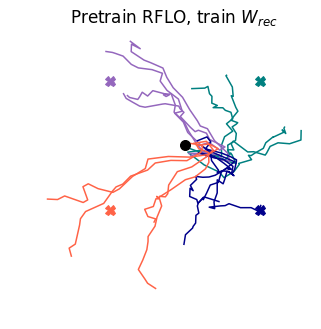

In [5]:
rnn_seed = 72
pretrain_duration = 2500
train_duration = 1500
test_duration = 500


# Set RNN Parameters
params = RNNparams(n_in=4,n_rec=50,n_out=2,tau_rec=10,
               eta_in=0.1,eta_rec=0.1,eta_out=0.1,
               sig_in=0.0,sig_rec=0.25,sig_out=0.01,
               velocity_transform=False, tau_vel = 0.8, dt_vel = 0.1,
               rng=np.random.RandomState(rnn_seed))
params.print_params()



# Initialize RNN
net0 = RNN(params)
sim0 = Simulation(net0)
rflo = RFLO(net0,apply_to=['w_rec'],online=False)
sim0.run_session(n_trials=pretrain_duration, tasks=[task1,task2,task3,task4], learn_alg=[rflo], probe_types=['loss'], plot=True, plot_freq=20)

fig0 = plot_trained_trajectories(sim=sim0, tasks=[task1,task2,task3,task4],title='Pretrain RFLO, train '+r'$W_{rec}$')








6it [00:00, 55.60it/s]

M norm: 1.03	 M angle: 0.59, 6 iterations
w_out1 norm: 1.60	 w_out vs. w_out1 angle: 0.41
w_m norm: 1.03	 w_out1 vs. w_m angle: 0.59
w_m norm: 1.72	 w_out vs. w_m angle: 0.27

500it [00:05, 91.52it/s]
1500it [00:22, 65.73it/s]
500it [00:04, 116.59it/s]
10it [00:00, 96.54it/s]

M norm: 1.13	 M angle: 0.59, 4 iterations
w_out1 norm: 1.37	 w_out vs. w_out1 angle: 0.60
w_m norm: 1.13	 w_out1 vs. w_m angle: 0.59
w_m norm: 1.69	 w_out vs. w_m angle: 0.32

500it [00:04, 116.88it/s]
1500it [00:20, 74.49it/s]
500it [00:04, 114.84it/s]
10it [00:00, 99.08it/s]

M norm: 1.25	 M angle: 0.61, 5 iterations
w_out1 norm: 1.02	 w_out vs. w_out1 angle: 0.80
w_m norm: 1.25	 w_out1 vs. w_m angle: 0.61
w_m norm: 1.58	 w_out vs. w_m angle: 0.44

500it [00:05, 87.05it/s] 
1500it [00:17, 84.83it/s]
500it [00:04, 112.93it/s]
8it [00:00, 77.18it/s]

M norm: 1.37	 M angle: 0.60, 51 iterations
w_out1 norm: 0.00	 w_out vs. w_out1 angle: 1.00
w_m norm: 1.37	 w_out1 vs. w_m angle: 0.60
w_m norm: 1.37	 w_out vs. w_m angle: 0.60

500it [00:04, 103.64it/s]
1500it [00:38, 15.57it/s]
500it [00:04, 109.86it/s]
13it [00:00, 124.19it/s]

M norm: 0.96	 M angle: 0.60, 28 iterations
w_out1 norm: 1.60	 w_out vs. w_out1 angle: 0.40
w_m norm: 0.96	 w_out1 vs. w_m angle: 0.60
w_m norm: 1.76	 w_out vs. w_m angle: 0.19

500it [00:04, 118.24it/s]
1500it [00:16, 93.56it/s]
500it [00:04, 120.72it/s]
10it [00:00, 96.61it/s]

M norm: 1.08	 M angle: 0.60, 40 iterations
w_out1 norm: 1.35	 w_out vs. w_out1 angle: 0.61
w_m norm: 1.08	 w_out1 vs. w_m angle: 0.60
w_m norm: 1.65	 w_out vs. w_m angle: 0.34

500it [00:04, 120.14it/s]
1500it [00:20, 74.57it/s]
500it [00:04, 101.10it/s]
9it [00:00, 89.50it/s]

M norm: 1.21	 M angle: 0.61, 8 iterations
w_out1 norm: 1.01	 w_out vs. w_out1 angle: 0.80
w_m norm: 1.21	 w_out1 vs. w_m angle: 0.61
w_m norm: 1.48	 w_out vs. w_m angle: 0.50

500it [00:04, 107.51it/s]
1500it [00:18, 81.77it/s]
500it [00:04, 111.83it/s]
8it [00:00, 76.15it/s]

M norm: 1.35	 M angle: 0.61, 19 iterations
w_out1 norm: 0.00	 w_out vs. w_out1 angle: 1.00
w_m norm: 1.35	 w_out1 vs. w_m angle: 0.61
w_m norm: 1.35	 w_out vs. w_m angle: 0.61

500it [00:04, 106.62it/s]
1500it [00:30, 48.99it/s]
500it [00:04, 104.84it/s]


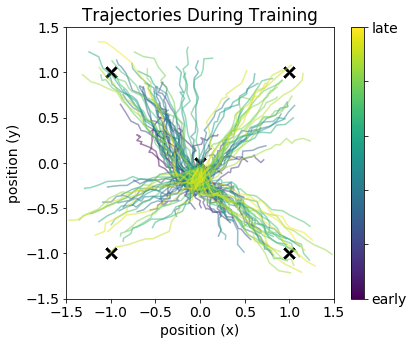

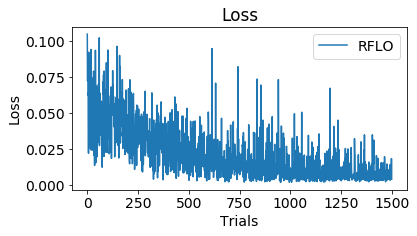

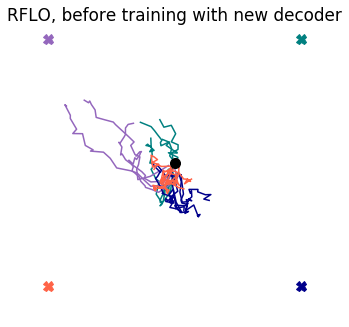

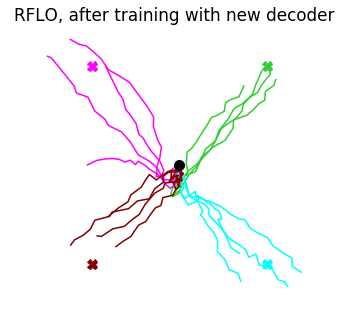

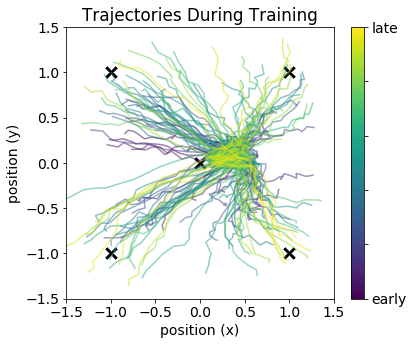

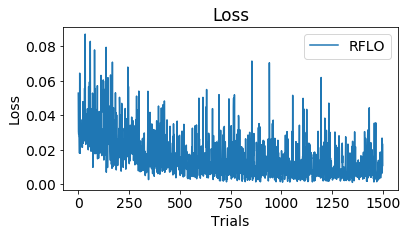

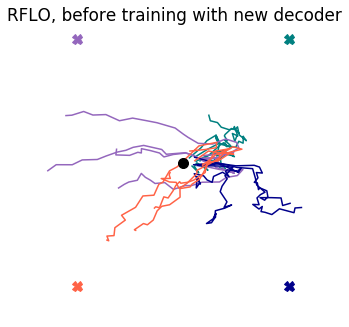

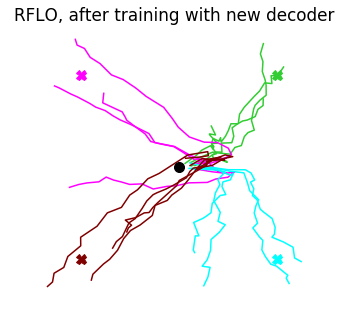

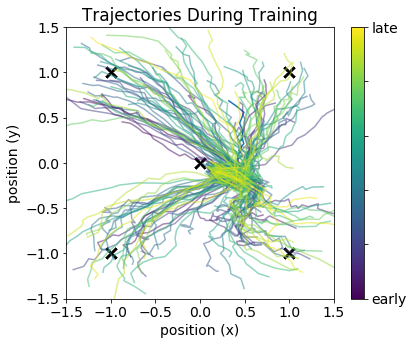

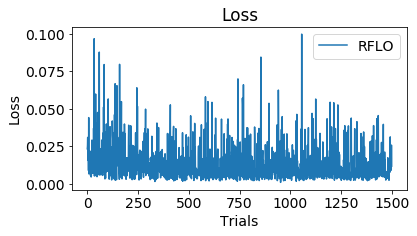

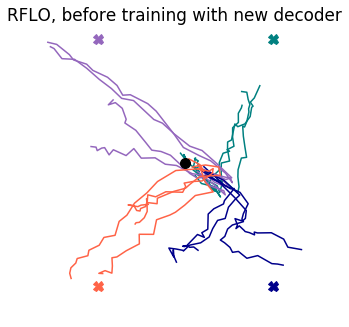

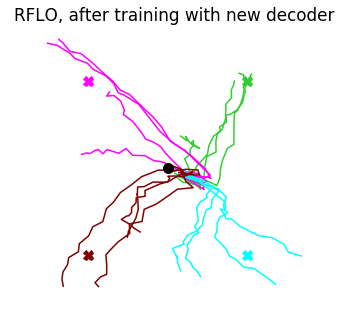

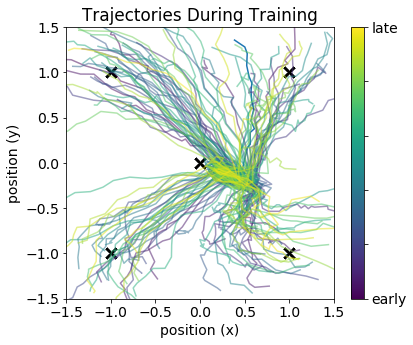

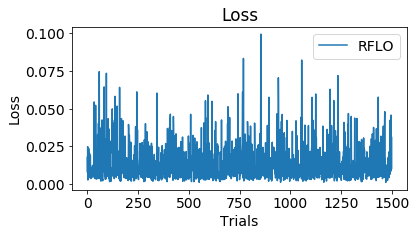

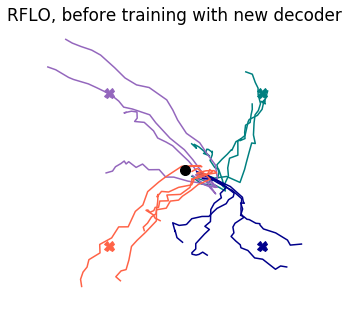

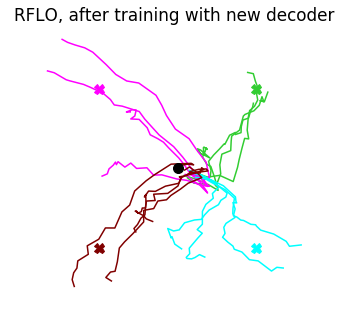

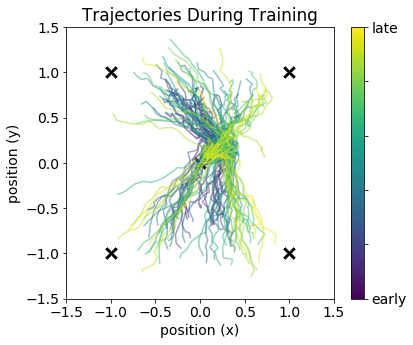

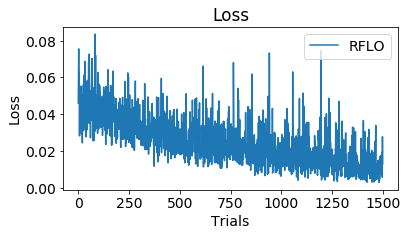

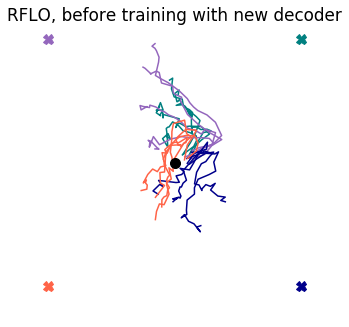

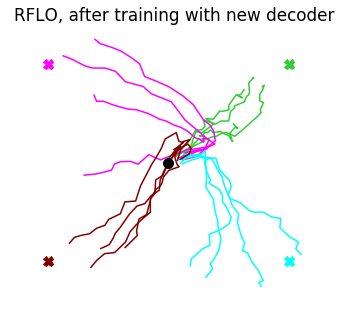

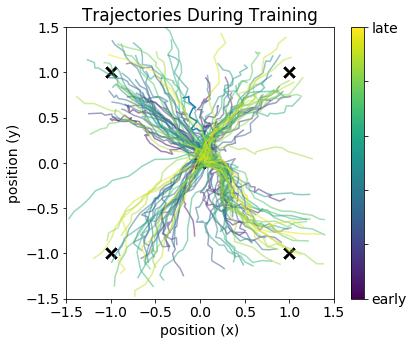

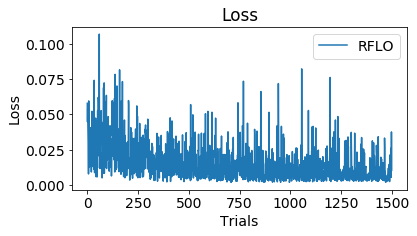

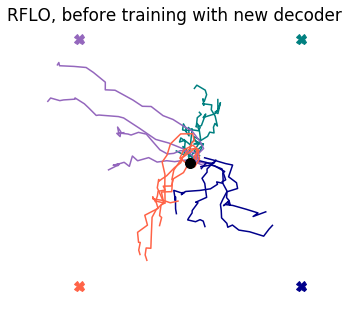

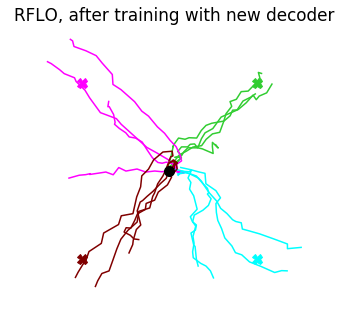

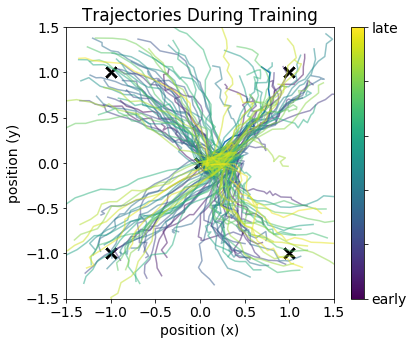

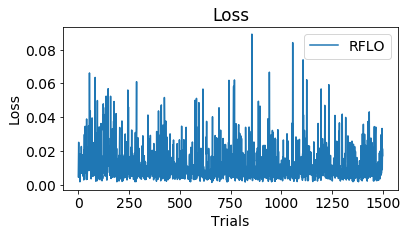

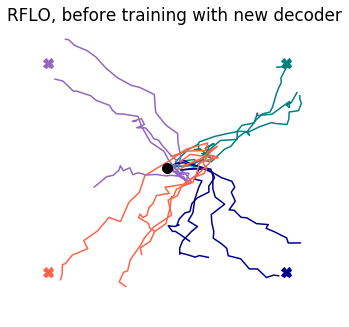

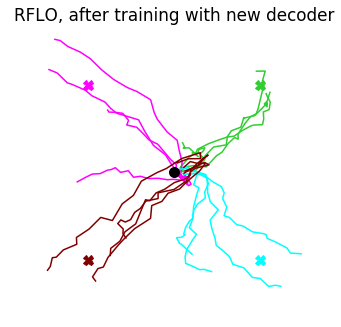

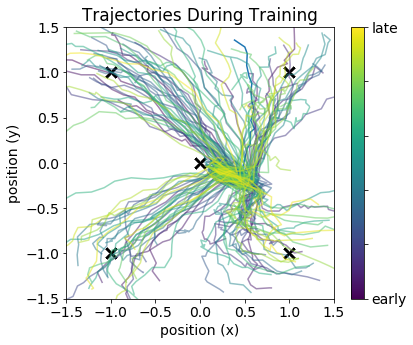

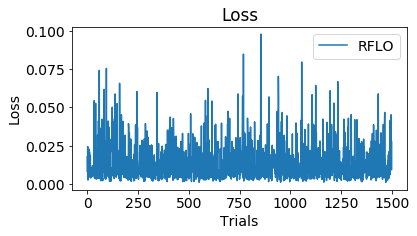

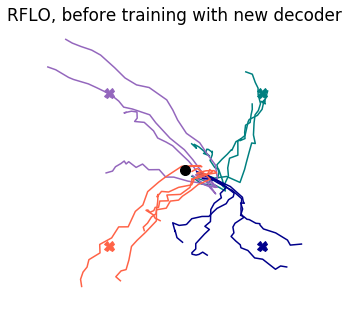

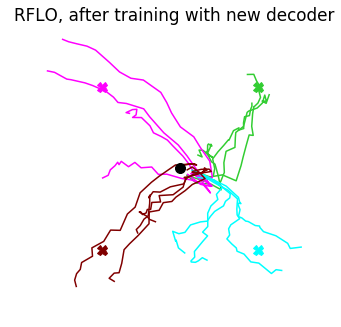

In [34]:
""" Average over multiple seeds """
seeds = [0,22]
# overlaps = [0.5]
# n_changes = [50]
overlap = 0.6
n_change = 40
#overlap_w_out0 = 0.8 # 0.5
#n_change_w_out0 = 20 #50
overlaps_w_out0 = [0.4,0.6,0.8,1] # 0.5
n_changes_w_out0 = [60,40,20,0] #50


stats = {}
stats['pearson_list'] = []
stats['cov_pre_list'] = []
stats['cov_post_list'] = []

stats['seeds'] = seeds
stats['overlaps'] = overlaps
stats['n_changes'] = n_changes
stats['overlap_w_out0'] = overlap_w_out0
stats['n_change_w_out0'] = n_change_w_out0
stats['frac_on'] = frac_on
stats['RNNparams'] = params
stats['pretrain_duration'] = pretrain_duration
stats['train_duration'] = train_duration
stats['test_duration'] = test_duration
stats['rnn_seed'] = rnn_seed
stats['comments'] = 'vary overlap between M and w_out1'

for seed in seeds:

    pearson_list = []
    cov_pre_list = []
    cov_post_list = []
    

    #for overlap,n_change in zip(overlaps,n_changes):
    for overlap_w_out0,n_change_w_out0 in zip(overlaps_w_out0,n_changes_w_out0):
        
        """ let overlap between w_out0 and w_out1 be constant """
        w_out1 = choose_aligned_matrix(net0.w_out.copy(),n_change=n_change_w_out0,overlap=overlap_w_out0,rng=np.random.RandomState(seed),zero=False,tolerance=0.01,loop=1000)
        """ change overlap between w_out1 and w_m  """
        w_m = choose_aligned_matrix(w_out1,n_change=n_change,overlap=overlap,rng=np.random.RandomState(seed),zero=False,tolerance=0.01,loop=1000)

        # confirm overlap between w_out1 and w_out
        norm, angle = return_norm_and_angle(net0.w_out,w_out1)
        print('\nw_out1 norm: {:.2f}'.format(norm) + '\t w_out vs. w_out1 angle: {:.2f}'.format(angle),end='')

        # confirm overlap between w_out1 and w_m
        norm, angle = return_norm_and_angle(w_out1,w_m)
        print('\nw_m norm: {:.2f}'.format(norm) + '\t w_out1 vs. w_m angle: {:.2f}'.format(angle),end='')

        # confirm overlap between w_out and w_m
        norm, angle = return_norm_and_angle(net0.w_out,w_m)
        print('\nw_m norm: {:.2f}'.format(norm) + '\t w_out vs. w_m angle: {:.2f}'.format(angle),end='')
        
        
        
        
        net1_pre = RNN(params)
        net1_pre.set_weights(w_in=net0.w_in.copy(), w_rec=net0.w_rec.copy())
        net1_pre.set_weights(w_out = w_out1)
        net1_pre.set_weights(w_m = w_m.T)

        # unfortunately I need to make a different network to maintain integrity of pre and post simulations for plotting
        net1 = RNN(params)
        net1.set_weights(w_in=net0.w_in.copy(), w_rec=net0.w_rec.copy())
        net1.set_weights(w_out = w_out1)
        net1.set_weights(w_m = w_m.T)




        """ Track activity with new decoder, before training """

        sim1_pre = Simulation(net1_pre)
        trackvars = TrackVars(net1_pre,apply_to=[]) 
        #sim1_pre.run_session(n_trials=test_duration, tasks=[task1,task2,task3,task4], learn_alg=[trackvars], probe_types=['h','err'], plot=False, plot_freq=10)
        sim1_pre.run_session(n_trials=test_duration, tasks=[task1], learn_alg=[trackvars], probe_types=['h','err'], plot=False, plot_freq=10)

        #fig = plot_trained_trajectories(sim=sim1_pre, tasks=[task1,task2,task3,task4],title='RFLO, before training with new decoder')

        """ Train with new decoder """

        sim1_train = Simulation(net1)
        rflo = RFLO(net1,apply_to=['w_rec'],online=False)
        sim1_train.run_session(n_trials=train_duration, tasks=[task1,task2,task3,task4], learn_alg=[rflo], probe_types=['h','loss','err'], plot=True, plot_freq=10)

        """ Track activity with new decoder, after training """
        net1_post = RNN(params)
        net1_post.set_weights(w_in=net1.w_in.copy(), w_rec=net1.w_rec.copy())
        net1_post.set_weights(w_out = net1.w_out)
        net1_post.set_weights(w_m = net1.w_m)

        sim1_post = Simulation(net1_post)
        trackvars = TrackVars(net1_post,apply_to=[]) 
        #sim1_post.run_session(n_trials=test_duration, tasks=[task1,task2,task3,task4], learn_alg=[trackvars], probe_types=['h','err'], plot=False, plot_freq=10)
        sim1_post.run_session(n_trials=test_duration, tasks=[task1], learn_alg=[trackvars], probe_types=['h','err'], plot=False, plot_freq=10)

        
        fig = plot_trained_trajectories(sim=sim1_pre, tasks=[task1,task2,task3,task4],title='RFLO, before training with new decoder')

        fig = plot_trained_trajectories(sim=sim1_post, tasks=[task1,task2,task3,task4],title='RFLO, after training with new decoder')
        
        
        
        
        """ Keep track of Covariance Changes """
        activity_pre = np.array(sim1_pre.session_probes['h']).squeeze()
        task_mn_pre = np.mean(activity_pre,0) # average across 500 trials
        cov_pre = np.cov(task_mn_pre.T)

        activity_post = np.array(sim1_post.session_probes['h']).squeeze()
        task_mn_post = np.mean(activity_post,0) # average across 500 trials
        cov_post = np.cov(task_mn_post.T)

        p_r = pearsonr(cov_pre.ravel(),cov_post.ravel())
        
        pearson_list.append(p_r[0])
        cov_pre_list.append(cov_pre)
        cov_post_list.append(cov_post)
        
     
        
        
    stats['pearson_list'].append(pearson_list)
    stats['cov_pre_list'].append(cov_pre_list)
    stats['cov_post_list'].append(cov_post_list)
        
        



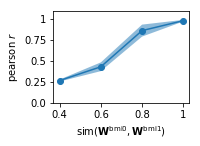

In [36]:

save = True
paper = True


fig,ax = plt.subplots(1,1)
lw = 1
fs = 18

n_samples = np.array(stats['pearson_list']).shape[0]
y = np.mean(np.array(stats['pearson_list']),0)
std = np.std(np.array(stats['pearson_list']),axis=0)
sem = std/np.sqrt(n_samples)
plt.plot(overlaps_w_out0,y,'o-')
plt.fill_between(overlaps_w_out0,y-std,y+std,alpha=0.5)

plt.ylim([0,1])
plt.ylabel('pearson ' + r'$r$')
plt.xlabel('sim('+r'$\mathbf{W}^{\mathrm{bmi}0},\mathbf{W}^{\mathrm{bmi}1})$',fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

if paper:
    
    fig,ax = paper_format(fig=fig,ax=ax,xlabels=[0.4,0.6,0.8,1],ylabels=[0.,0.25,0.5,0.75,1],ticksize=10,linewidth=2,ylim=[0,1.1],figsize=(2.25,3))

    
else:
    plt.ylim([-0.2,0.8])


plt.tight_layout()
plt.show()


if save:
    if paper:
        fig.savefig(folder+'fig-appendix-covariance-Mwbmi1-06.pdf')
    else:
        fig.savefig(folder+'fig-appendix-covariance-Mwbmi1-06.pdf')


In [59]:
len(stats['cov_pre_list'][0])

4

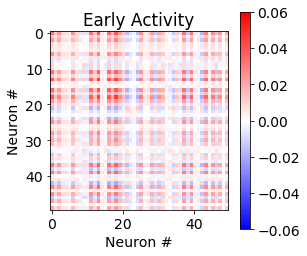

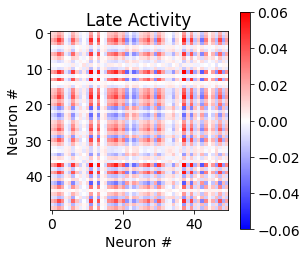

In [66]:
save = True
paper = True


fig1,ax1 = plt.subplots(1,1,figsize=(4,4))
fig2,ax2 = plt.subplots(1,1,figsize=(4,4))
lw = 1
fs = 18

f = ax1.imshow(stats['cov_pre_list'][0][2],cmap='bwr',vmin=-0.06,vmax=0.06)
plt.sca(ax1)
plt.colorbar(f,ax=ax1)
ax1.set_title('Early Activity')
ax1.set_xlabel('Neuron #')
ax1.set_ylabel('Neuron #')
#plt.show()

f = ax2.imshow(stats['cov_post_list'][0][2],cmap='bwr',vmin=-0.06,vmax=0.06)
plt.colorbar(f,ax=ax2)
ax2.set_title('Late Activity')
ax2.set_xlabel('Neuron #')
ax2.set_ylabel('Neuron #')
#plt.show()

# if paper:
    
#     fig,ax = paper_format(fig=fig1,ax=ax1,ticksize=10,linewidth=2,figsize=(5,5))

    
# else:
#     plt.ylim([-0.2,0.8])


# plt.tight_layout()
# plt.show()


if save:
    if paper:
        fig1.savefig(folder+'fig-appendix-covariance-matrix-pre-Mwbmi1-06.pdf')
        fig2.savefig(folder+'fig-appendix-covariance-matrix-post-Mwbmi1-06.pdf')
#     else:
#         fig1.savefig(folder+'fig-appendix-covariance-matrix-pre-Mwbmi1-06.pdf')
#         fig2.savefig(folder+'fig-appendix-covariance-matrix-post-Mwbmi1-06.pdf')

# Apply Analysis to _Middle_ of training

8it [00:00, 79.69it/s]

M norm: 1.03	 M angle: 0.59, 6 iterations
w_out1 norm: 1.60	 w_out vs. w_out1 angle: 0.41
w_m norm: 1.03	 w_out1 vs. w_m angle: 0.59
w_m norm: 1.72	 w_out vs. w_m angle: 0.27

500it [00:05, 91.35it/s]
1500it [00:24, 61.27it/s]
500it [00:04, 109.60it/s]
8it [00:00, 79.84it/s]

dim_pre:  1.40596044772532
dim_post:  1.1891207119564955
p_r_train:(0.7886981562243766, 0.0)
M norm: 1.12	 M angle: 0.59, 4 iterations
w_out1 norm: 1.52	 w_out vs. w_out1 angle: 0.51
w_m norm: 1.12	 w_out1 vs. w_m angle: 0.59
w_m norm: 1.67	 w_out vs. w_m angle: 0.34

500it [00:04, 108.96it/s]
1500it [00:20, 71.98it/s]
500it [00:04, 104.95it/s]
10it [00:00, 96.81it/s]

dim_pre:  1.40596044772532
dim_post:  1.2840453291556289
p_r_train:(0.8035697755278988, 0.0)
M norm: 1.13	 M angle: 0.59, 4 iterations
w_out1 norm: 1.37	 w_out vs. w_out1 angle: 0.60
w_m norm: 1.13	 w_out1 vs. w_m angle: 0.59
w_m norm: 1.69	 w_out vs. w_m angle: 0.32

500it [00:04, 124.18it/s]
1500it [00:15, 95.21it/s] 
500it [00:04, 106.34it/s]
9it [00:00, 88.49it/s]

dim_pre:  1.40596044772532
dim_post:  1.3738225048050312
p_r_train:(0.7959093613625212, 0.0)
M norm: 1.13	 M angle: 0.60, 23 iterations
w_out1 norm: 1.20	 w_out vs. w_out1 angle: 0.70
w_m norm: 1.13	 w_out1 vs. w_m angle: 0.60
w_m norm: 1.47	 w_out vs. w_m angle: 0.50

500it [00:04, 104.23it/s]
1500it [00:15, 96.97it/s]
500it [00:04, 124.30it/s]
11it [00:00, 107.01it/s]

dim_pre:  1.40596044772532
dim_post:  1.3597254807792172
p_r_train:(0.9733020195780805, 0.0)
M norm: 1.25	 M angle: 0.61, 5 iterations
w_out1 norm: 1.02	 w_out vs. w_out1 angle: 0.80
w_m norm: 1.25	 w_out1 vs. w_m angle: 0.61
w_m norm: 1.58	 w_out vs. w_m angle: 0.44

500it [00:04, 124.55it/s]
1500it [00:16, 92.12it/s]
500it [00:03, 119.49it/s]
7it [00:00, 63.55it/s]

dim_pre:  1.40596044772532
dim_post:  1.326746689527128
p_r_train:(0.9455739248045146, 0.0)
M norm: 1.29	 M angle: 0.60, 127 iterations
w_out1 norm: 0.75	 w_out vs. w_out1 angle: 0.89
w_m norm: 1.29	 w_out1 vs. w_m angle: 0.60
w_m norm: 1.51	 w_out vs. w_m angle: 0.49

500it [00:04, 113.38it/s]
1500it [00:19, 77.29it/s]
500it [00:03, 125.89it/s]
0it [00:00, ?it/s]

dim_pre:  1.40596044772532
dim_post:  1.3541063708014578
p_r_train:(0.9725959297581355, 0.0)
M norm: 1.37	 M angle: 0.60, 51 iterations
w_out1 norm: 0.00	 w_out vs. w_out1 angle: 1.00
w_m norm: 1.37	 w_out1 vs. w_m angle: 0.60
w_m norm: 1.37	 w_out vs. w_m angle: 0.60

500it [00:05, 94.72it/s] 
1500it [00:26, 56.40it/s]
500it [00:03, 125.15it/s]
8it [00:00, 76.45it/s]

dim_pre:  1.40596044772532
dim_post:  1.413093476835795
p_r_train:(0.9903001161539584, 0.0)
M norm: 1.05	 M angle: 0.60, 34 iterations
w_out1 norm: 1.65	 w_out vs. w_out1 angle: 0.39
w_m norm: 1.05	 w_out1 vs. w_m angle: 0.60
w_m norm: 1.86	 w_out vs. w_m angle: 0.13

500it [00:04, 122.87it/s]
1500it [00:21, 68.21it/s]
500it [00:04, 124.37it/s]
7it [00:00, 68.88it/s]

dim_pre:  1.40596044772532
dim_post:  1.433934905813005
p_r_train:(0.7607287687392594, 0.0)
M norm: 1.08	 M angle: 0.61, 5 iterations
w_out1 norm: 1.53	 w_out vs. w_out1 angle: 0.49
w_m norm: 1.08	 w_out1 vs. w_m angle: 0.61
w_m norm: 1.72	 w_out vs. w_m angle: 0.28

500it [00:03, 125.41it/s]
1500it [00:22, 68.00it/s]
500it [00:03, 117.52it/s]
10it [00:00, 93.44it/s]

dim_pre:  1.40596044772532
dim_post:  1.328081754662858
p_r_train:(0.8652975300330793, 0.0)
M norm: 1.12	 M angle: 0.61, 86 iterations
w_out1 norm: 1.39	 w_out vs. w_out1 angle: 0.59
w_m norm: 1.12	 w_out1 vs. w_m angle: 0.61
w_m norm: 1.76	 w_out vs. w_m angle: 0.26

500it [00:04, 124.55it/s]
1500it [00:18, 79.21it/s]
500it [00:03, 128.34it/s]
12it [00:00, 113.41it/s]

dim_pre:  1.40596044772532
dim_post:  1.3111418948466693
p_r_train:(0.8925012820785988, 0.0)
M norm: 1.21	 M angle: 0.60, 44 iterations
w_out1 norm: 1.21	 w_out vs. w_out1 angle: 0.71
w_m norm: 1.21	 w_out1 vs. w_m angle: 0.60
w_m norm: 1.71	 w_out vs. w_m angle: 0.33

500it [00:03, 125.93it/s]
1500it [00:36, 41.30it/s]
500it [00:03, 125.36it/s]
11it [00:00, 108.18it/s]

dim_pre:  1.40596044772532
dim_post:  1.3425346602214059
p_r_train:(0.8897394251684123, 0.0)
M norm: 1.22	 M angle: 0.61, 27 iterations
w_out1 norm: 1.02	 w_out vs. w_out1 angle: 0.80
w_m norm: 1.22	 w_out1 vs. w_m angle: 0.61
w_m norm: 1.53	 w_out vs. w_m angle: 0.46

500it [00:04, 122.83it/s]
1500it [00:26, 57.29it/s]
500it [00:03, 127.20it/s]
11it [00:00, 101.55it/s]

dim_pre:  1.40596044772532
dim_post:  1.312155888413133
p_r_train:(0.950868396897757, 0.0)
M norm: 1.32	 M angle: 0.59, 5 iterations
w_out1 norm: 0.72	 w_out vs. w_out1 angle: 0.90
w_m norm: 1.32	 w_out1 vs. w_m angle: 0.59
w_m norm: 1.49	 w_out vs. w_m angle: 0.50

500it [00:04, 124.85it/s]
1500it [00:18, 80.29it/s]
500it [00:03, 126.18it/s]
11it [00:00, 109.15it/s]

dim_pre:  1.40596044772532
dim_post:  1.3720185257984034
p_r_train:(0.9844578115353065, 0.0)
M norm: 1.39	 M angle: 0.59, 15 iterations
w_out1 norm: 0.00	 w_out vs. w_out1 angle: 1.00
w_m norm: 1.39	 w_out1 vs. w_m angle: 0.59
w_m norm: 1.39	 w_out vs. w_m angle: 0.59

500it [00:03, 125.67it/s]
1500it [00:32, 46.53it/s]
500it [00:05, 94.53it/s]
0it [00:00, ?it/s]

dim_pre:  1.40596044772532
dim_post:  1.4071762018508447
p_r_train:(0.9939190793669139, 0.0)
M norm: 1.02	 M angle: 0.60, 27 iterations
w_out1 norm: 1.62	 w_out vs. w_out1 angle: 0.40
w_m norm: 1.02	 w_out1 vs. w_m angle: 0.60
w_m norm: 1.77	 w_out vs. w_m angle: 0.20

500it [00:06, 77.11it/s] 
1500it [00:26, 57.27it/s]
500it [00:06, 80.25it/s]
6it [00:00, 54.73it/s]

dim_pre:  1.40596044772532
dim_post:  1.2536258640487503
p_r_train:(0.9046781160993336, 0.0)
M norm: 1.04	 M angle: 0.61, 31 iterations
w_out1 norm: 1.51	 w_out vs. w_out1 angle: 0.50
w_m norm: 1.04	 w_out1 vs. w_m angle: 0.61
w_m norm: 1.63	 w_out vs. w_m angle: 0.36

500it [00:09, 51.48it/s]
1500it [00:26, 57.44it/s]
500it [00:05, 122.01it/s]
8it [00:00, 77.18it/s]

dim_pre:  1.40596044772532
dim_post:  1.2424768941461115
p_r_train:(0.9013991173972375, 0.0)
M norm: 1.13	 M angle: 0.61, 0 iterations
w_out1 norm: 1.39	 w_out vs. w_out1 angle: 0.60
w_m norm: 1.13	 w_out1 vs. w_m angle: 0.61
w_m norm: 1.71	 w_out vs. w_m angle: 0.30

500it [00:04, 119.34it/s]
1500it [00:34, 43.42it/s]
500it [00:06, 77.11it/s] 
7it [00:00, 66.19it/s]

dim_pre:  1.40596044772532
dim_post:  1.4099761880716406
p_r_train:(0.9050225442364817, 0.0)
M norm: 1.19	 M angle: 0.59, 86 iterations
w_out1 norm: 1.20	 w_out vs. w_out1 angle: 0.71
w_m norm: 1.19	 w_out1 vs. w_m angle: 0.59
w_m norm: 1.60	 w_out vs. w_m angle: 0.41

500it [00:07, 70.79it/s]
1500it [00:27, 53.61it/s]
500it [00:04, 107.50it/s]
7it [00:00, 68.08it/s]

dim_pre:  1.40596044772532
dim_post:  1.3088846557292129
p_r_train:(0.9001450250607844, 0.0)
M norm: 1.22	 M angle: 0.60, 22 iterations
w_out1 norm: 0.99	 w_out vs. w_out1 angle: 0.81
w_m norm: 1.22	 w_out1 vs. w_m angle: 0.60
w_m norm: 1.51	 w_out vs. w_m angle: 0.48

500it [00:05, 84.03it/s] 
1500it [00:19, 75.43it/s]
500it [00:04, 100.22it/s]
6it [00:00, 54.48it/s]

dim_pre:  1.40596044772532
dim_post:  1.3542608709436592
p_r_train:(0.9809312359315101, 0.0)
M norm: 1.32	 M angle: 0.61, 227 iterations
w_out1 norm: 0.75	 w_out vs. w_out1 angle: 0.90
w_m norm: 1.32	 w_out1 vs. w_m angle: 0.61
w_m norm: 1.33	 w_out vs. w_m angle: 0.62

500it [00:04, 112.97it/s]
1500it [00:29, 51.28it/s]
500it [00:06, 72.37it/s]
7it [00:00, 67.42it/s]

dim_pre:  1.40596044772532
dim_post:  1.4009668014136323
p_r_train:(0.9872980184247138, 0.0)
M norm: 1.39	 M angle: 0.60, 97 iterations
w_out1 norm: 0.00	 w_out vs. w_out1 angle: 1.00
w_m norm: 1.39	 w_out1 vs. w_m angle: 0.60
w_m norm: 1.39	 w_out vs. w_m angle: 0.60

500it [00:05, 89.69it/s] 
1500it [00:26, 49.38it/s]
500it [00:04, 100.12it/s]


dim_pre:  1.40596044772532
dim_post:  1.3974631257635983
p_r_train:(0.9909643008388338, 0.0)


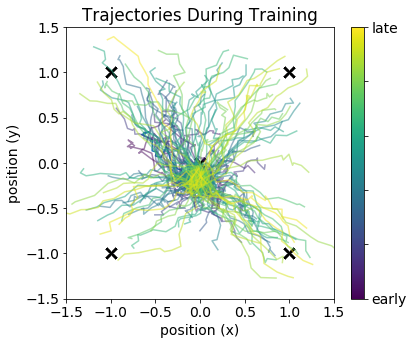

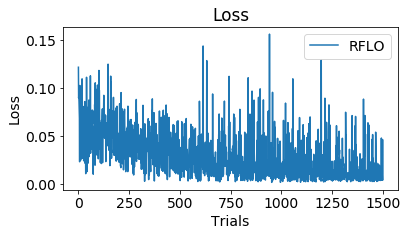

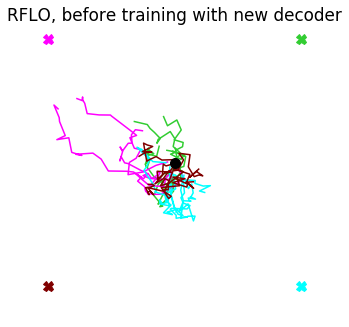

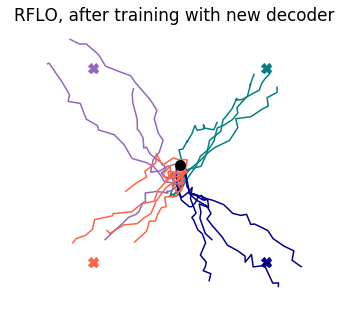

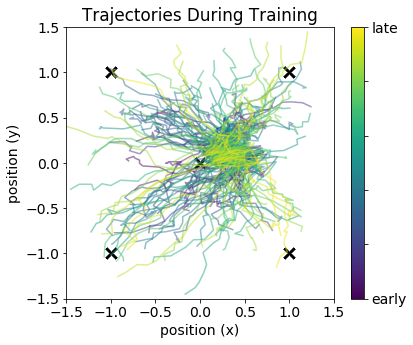

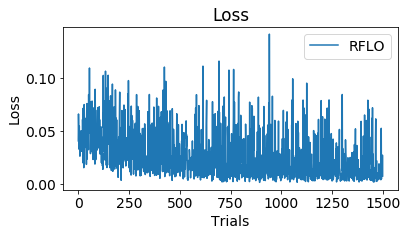

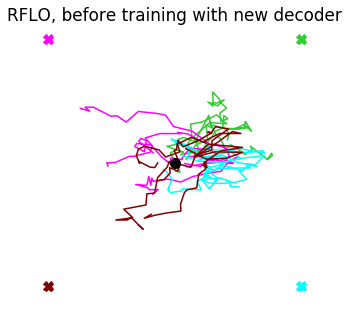

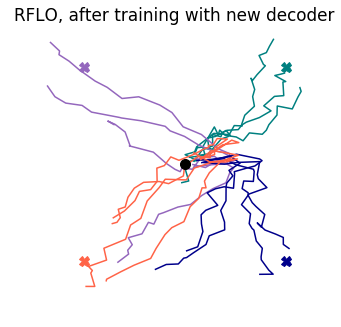

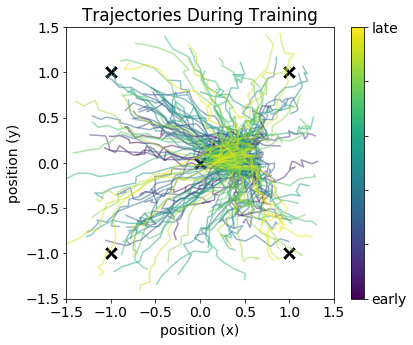

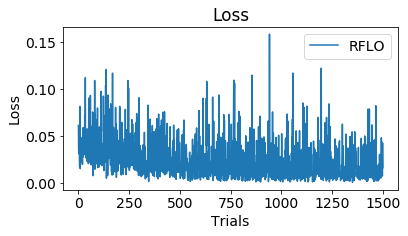

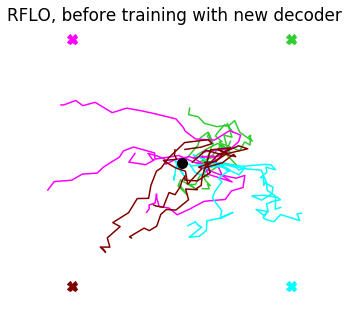

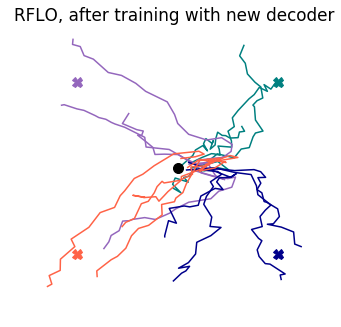

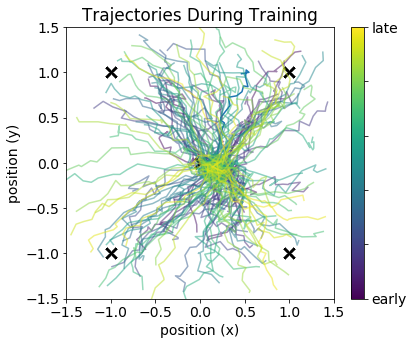

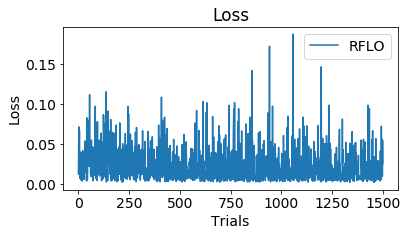

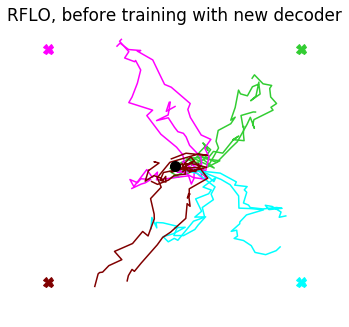

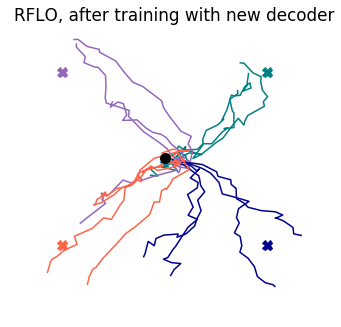

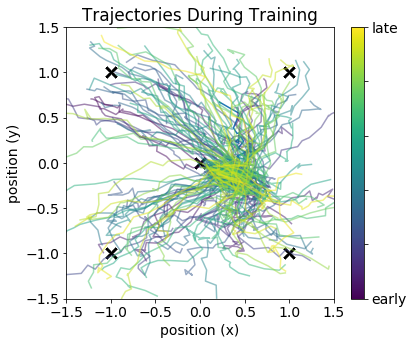

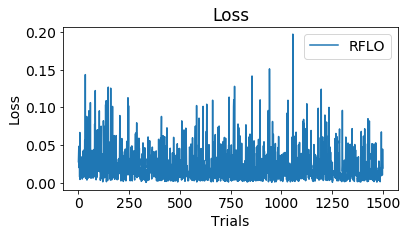

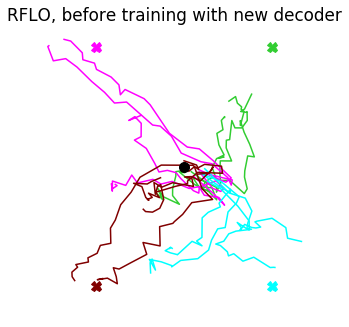

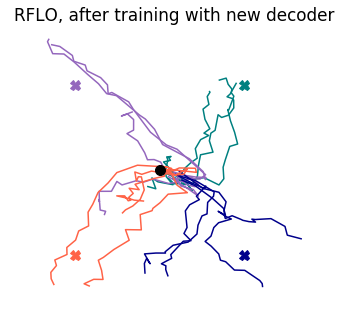

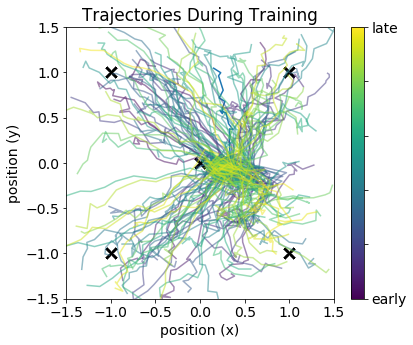

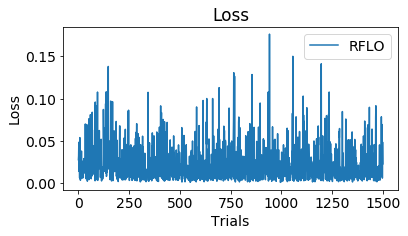

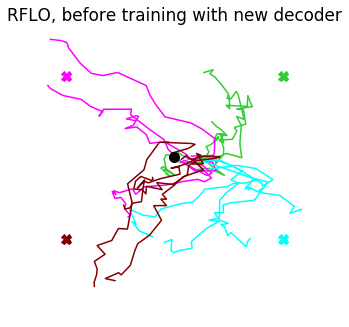

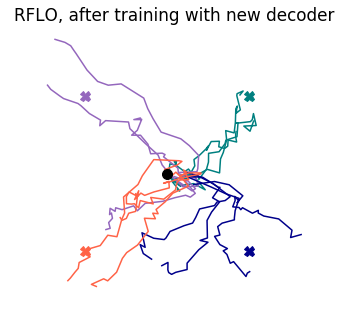

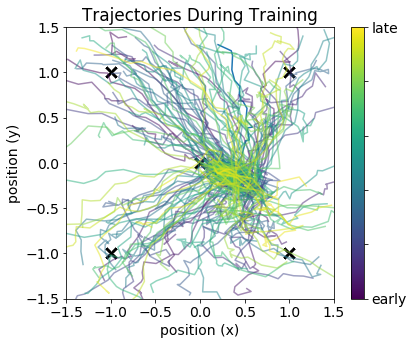

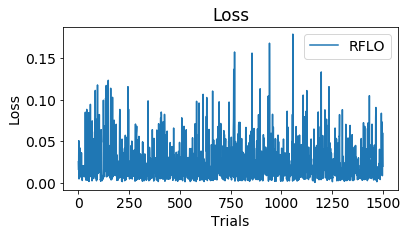

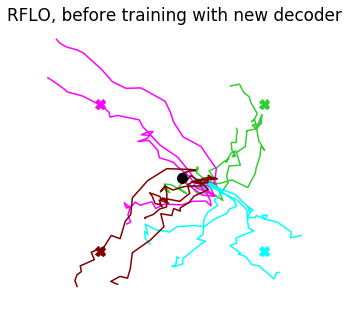

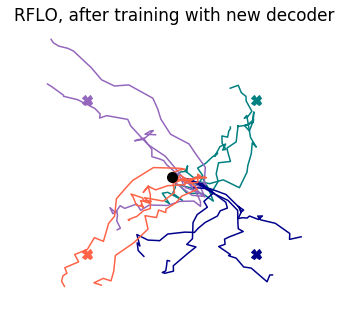

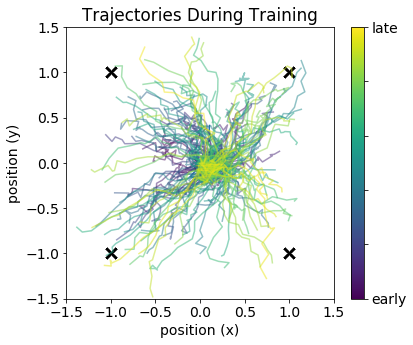

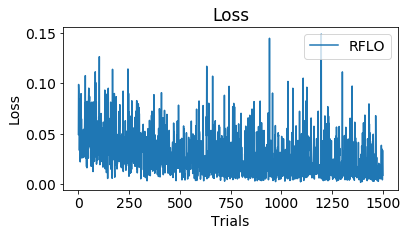

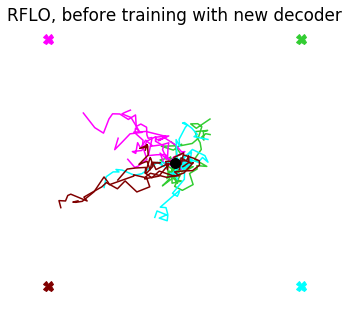

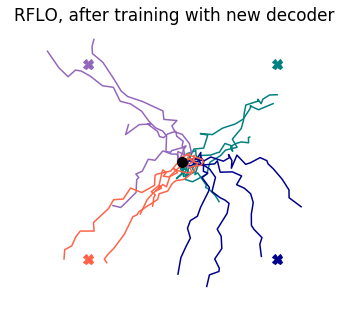

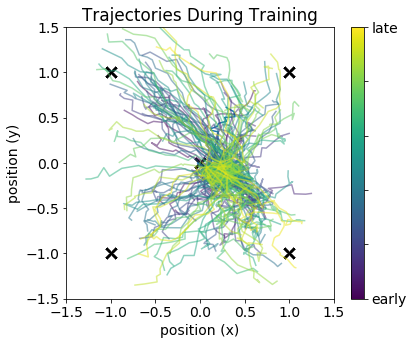

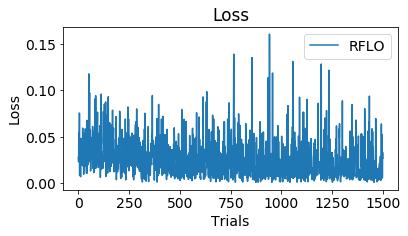

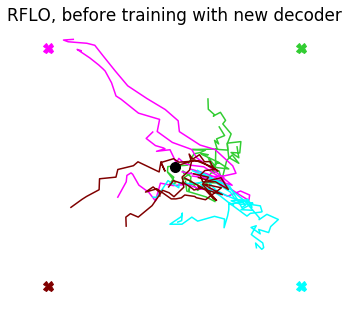

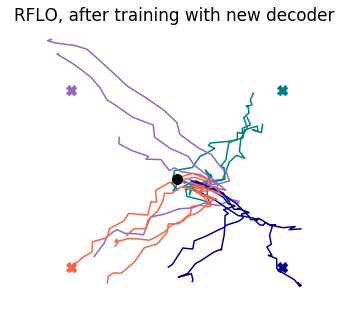

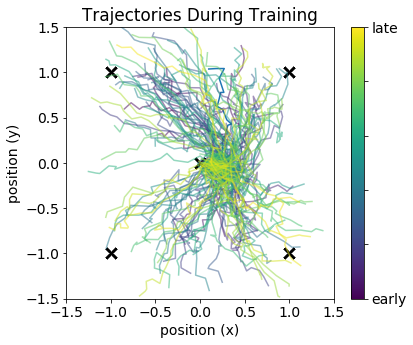

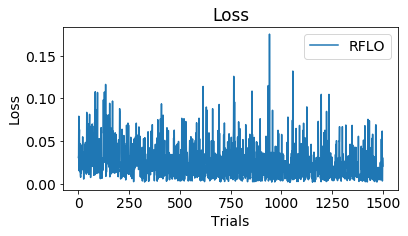

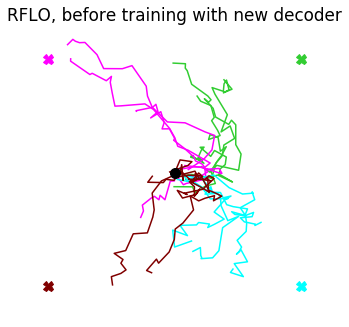

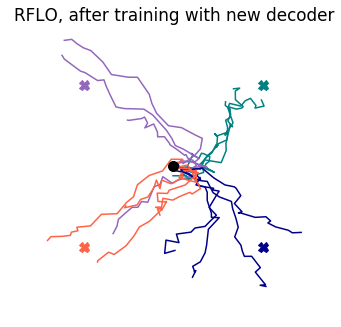

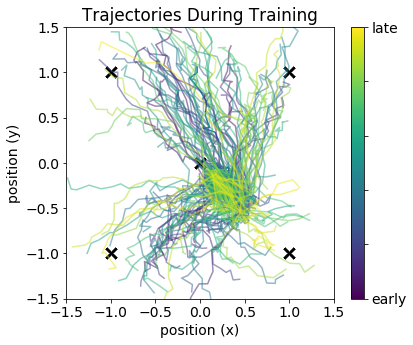

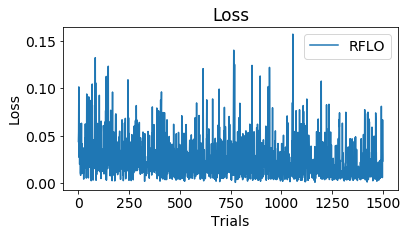

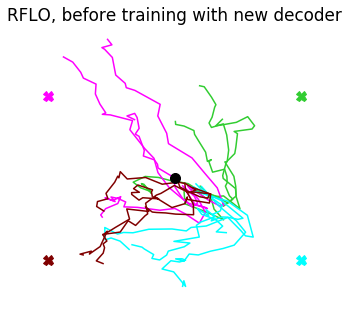

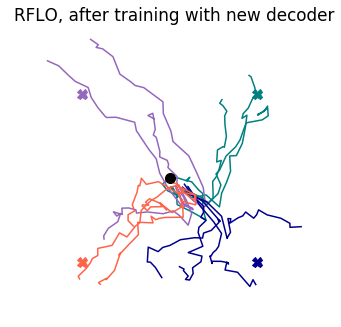

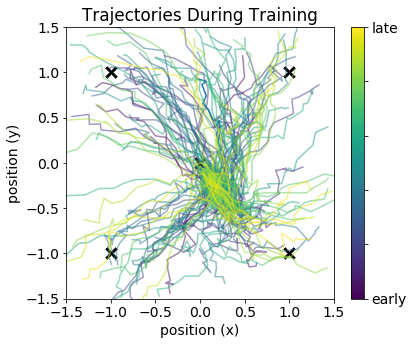

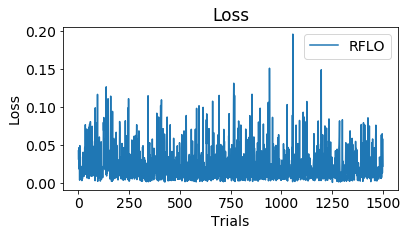

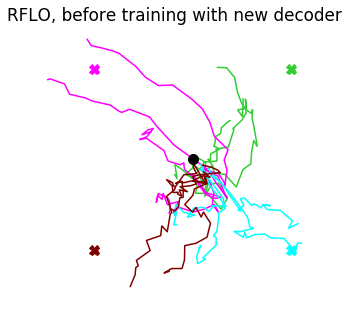

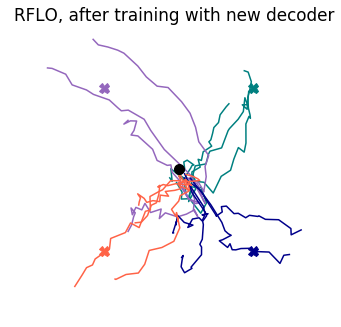

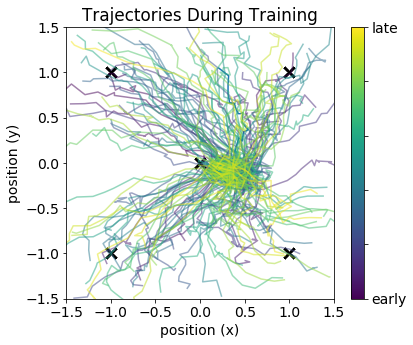

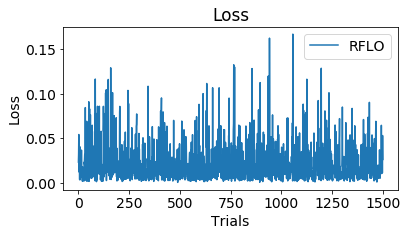

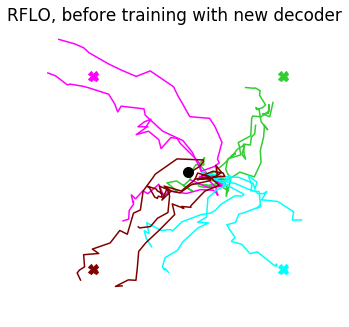

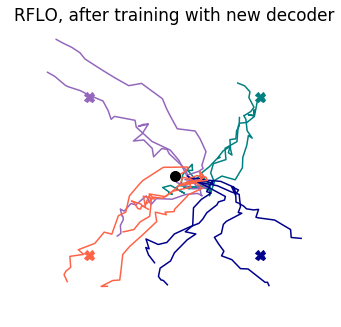

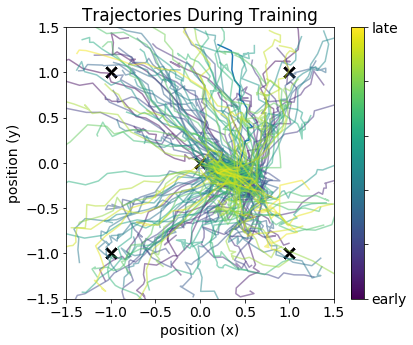

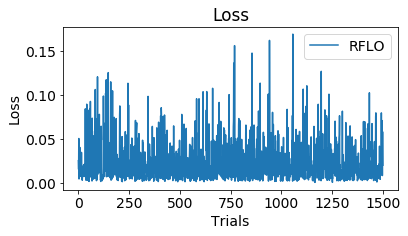

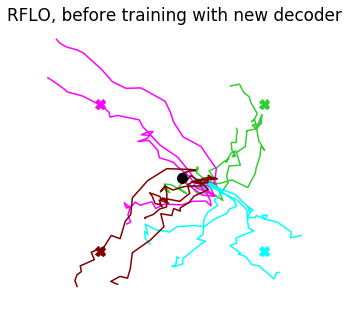

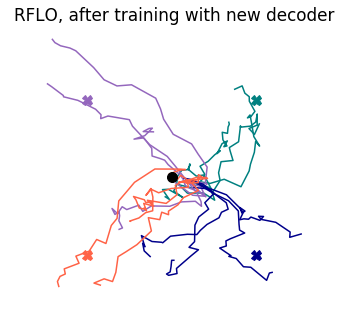

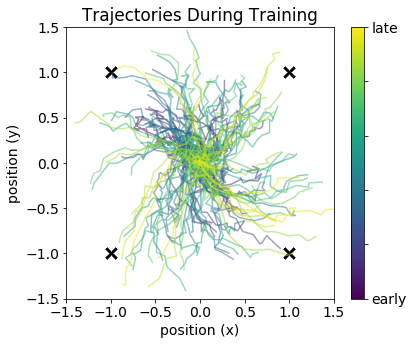

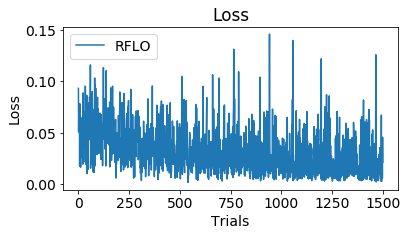

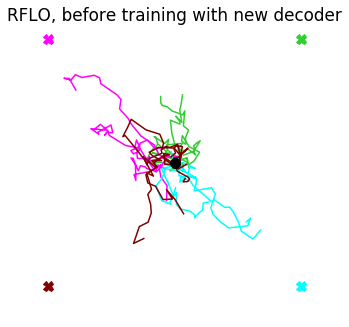

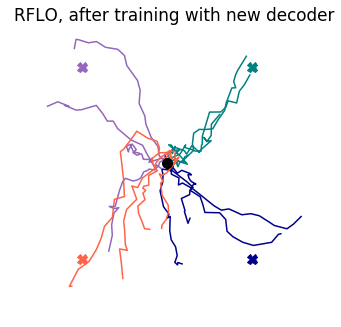

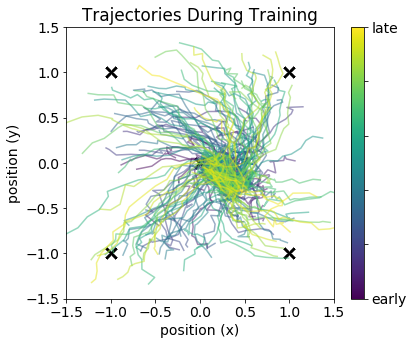

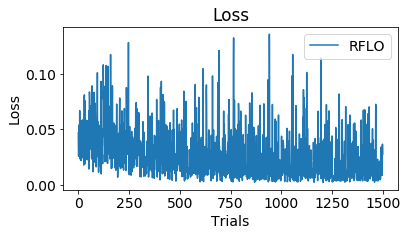

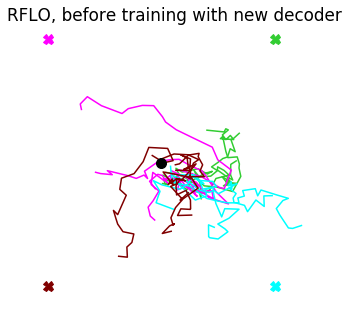

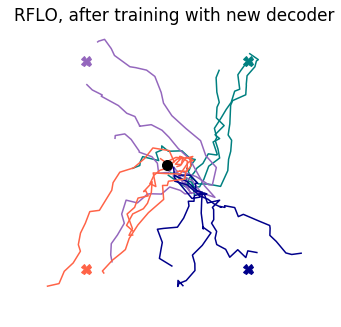

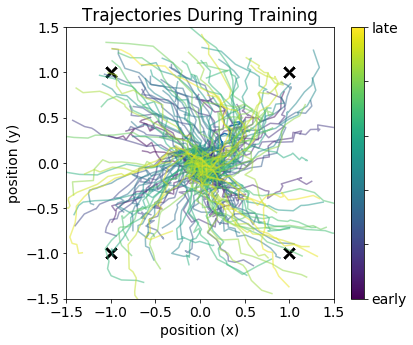

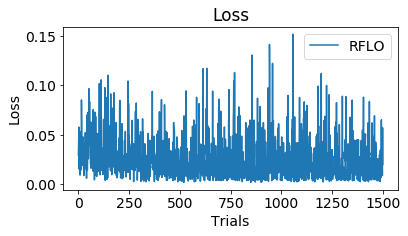

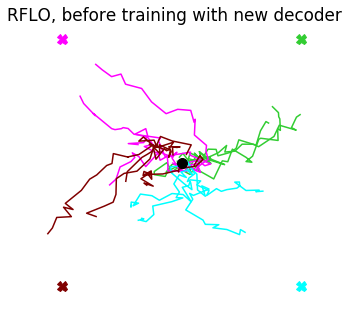

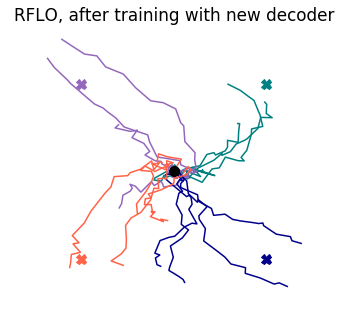

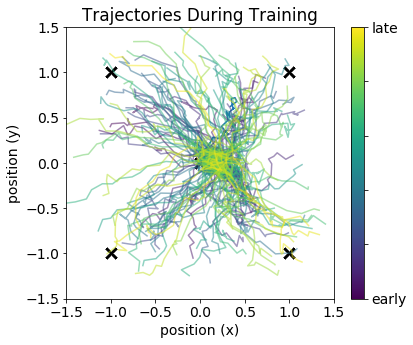

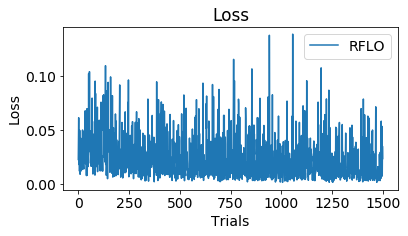

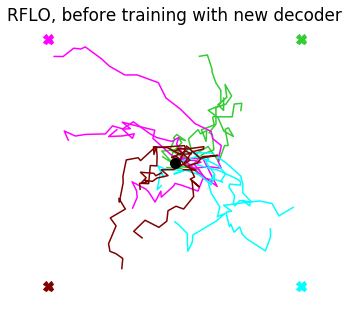

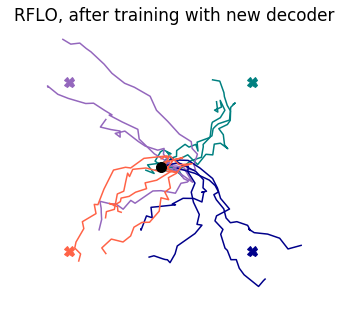

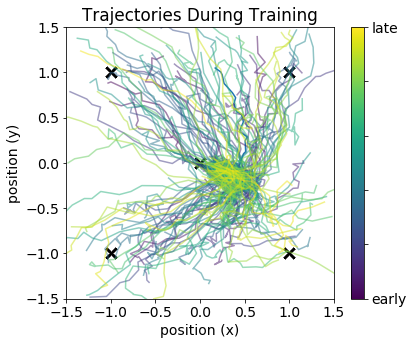

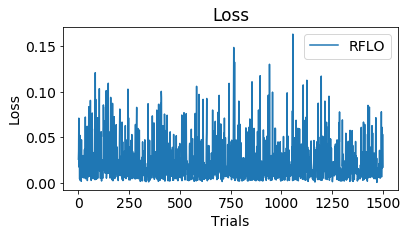

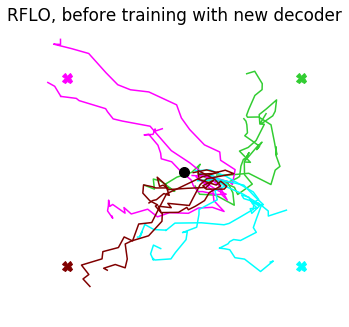

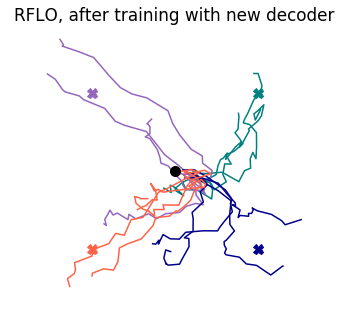

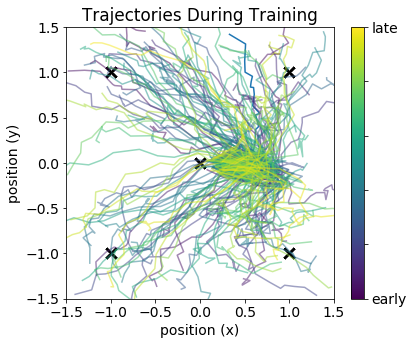

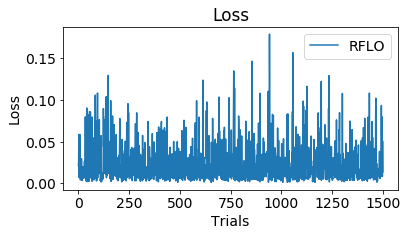

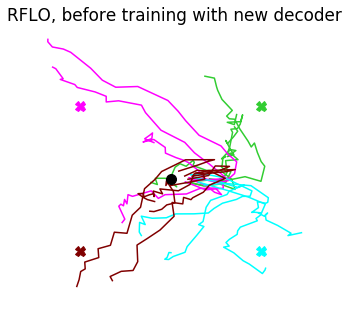

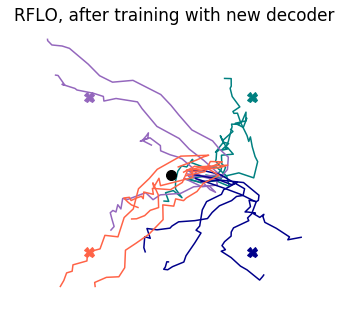

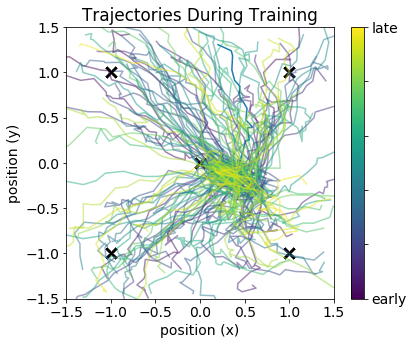

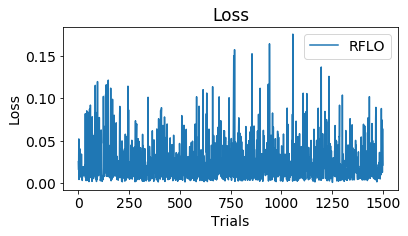

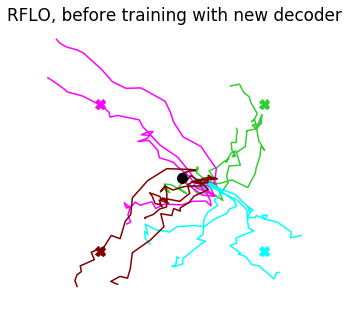

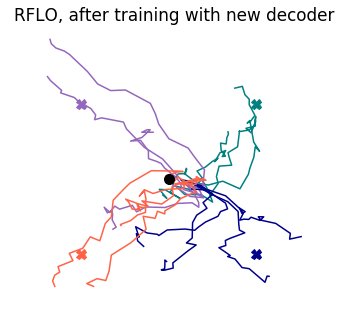

In [39]:
""" Average over multiple seeds """
seeds = [0,776,6887]
# overlaps = [0.5]
# n_changes = [50]
overlap = 0.6
n_change = 40
#overlap_w_out0 = 0.8 # 0.5
#n_change_w_out0 = 20 #50
overlaps_w_out0 =  [0.4,0.5,0.6,0.7,0.8,0.9,1] # 0.5 # [0.6,0.8]
n_changes_w_out0 =  [60,50,40,30,20,10,0] #50 # [40,20]


stats = {}
stats['pearson_list'] = []
stats['cov_pre_list'] = []
stats['cov_post_list'] = []
stats['pearson_train_list'] = []
stats['cov_train1_list'] = []
stats['cov_train2_list'] = []

stats['seeds'] = seeds
stats['overlap'] = overlap
stats['n_change'] = n_change
stats['overlaps_w_out0'] = overlaps_w_out0
stats['n_changes_w_out0'] = n_changes_w_out0
stats['frac_on'] = frac_on
stats['RNNparams'] = params
stats['pretrain_duration'] = pretrain_duration
stats['train_duration'] = train_duration
stats['test_duration'] = test_duration
stats['rnn_seed'] = rnn_seed
stats['comments'] = 'vary overlap between M and w_out1'

for seed in seeds:

    pearson_list = []
    cov_pre_list = []
    cov_post_list = []
    pearson_train_list = []
    cov_train1_list = []
    cov_train2_list = []
    

    #for overlap,n_change in zip(overlaps,n_changes):
    for overlap_w_out0,n_change_w_out0 in zip(overlaps_w_out0,n_changes_w_out0):
        
        """ let overlap between w_out0 and w_out1 be constant """
        w_out1 = choose_aligned_matrix(net0.w_out.copy(),n_change=n_change_w_out0,overlap=overlap_w_out0,rng=np.random.RandomState(seed),zero=False,tolerance=0.01,loop=1000)
        """ change overlap between w_out1 and w_m  """
        w_m = choose_aligned_matrix(w_out1,n_change=n_change,overlap=overlap,rng=np.random.RandomState(seed),zero=False,tolerance=0.01,loop=1000)

        # confirm overlap between w_out1 and w_out
        norm, angle = return_norm_and_angle(net0.w_out,w_out1)
        print('\nw_out1 norm: {:.2f}'.format(norm) + '\t w_out vs. w_out1 angle: {:.2f}'.format(angle),end='')

        # confirm overlap between w_out1 and w_m
        norm, angle = return_norm_and_angle(w_out1,w_m)
        print('\nw_m norm: {:.2f}'.format(norm) + '\t w_out1 vs. w_m angle: {:.2f}'.format(angle),end='')

        # confirm overlap between w_out and w_m
        norm, angle = return_norm_and_angle(net0.w_out,w_m)
        print('\nw_m norm: {:.2f}'.format(norm) + '\t w_out vs. w_m angle: {:.2f}'.format(angle),end='')
        
        
        
        
        net1_pre = RNN(params)
        net1_pre.set_weights(w_in=net0.w_in.copy(), w_rec=net0.w_rec.copy())
        net1_pre.set_weights(w_out = w_out1)
        net1_pre.set_weights(w_m = w_m.T)

        # unfortunately I need to make a different network to maintain integrity of pre and post simulations for plotting
        net1 = RNN(params)
        net1.set_weights(w_in=net0.w_in.copy(), w_rec=net0.w_rec.copy())
        net1.set_weights(w_out = w_out1)
        net1.set_weights(w_m = w_m.T)




        """ Track activity with new decoder, before training """

        sim1_pre = Simulation(net1_pre)
        trackvars = TrackVars(net1_pre,apply_to=[]) 
        #sim1_pre.run_session(n_trials=test_duration, tasks=[task1,task2,task3,task4], learn_alg=[trackvars], probe_types=['h','err'], plot=False, plot_freq=10)
        sim1_pre.run_session(n_trials=test_duration, tasks=[task1], learn_alg=[trackvars], probe_types=['h','err'], plot=False, plot_freq=10)

        #fig = plot_trained_trajectories(sim=sim1_pre, tasks=[task1,task2,task3,task4],title='RFLO, before training with new decoder')

        """ Train with new decoder """

        sim1_train = Simulation(net1)
        rflo = RFLO(net1,apply_to=['w_rec'],online=False)
        sim1_train.run_session(n_trials=train_duration, tasks=[task1,task2,task3,task4], learn_alg=[rflo], probe_types=['h','loss','err'], plot=True, plot_freq=10)

        """ Track activity with new decoder, after training """
        net1_post = RNN(params)
        net1_post.set_weights(w_in=net1.w_in.copy(), w_rec=net1.w_rec.copy())
        net1_post.set_weights(w_out = net1.w_out)
        net1_post.set_weights(w_m = net1.w_m)

        sim1_post = Simulation(net1_post)
        trackvars = TrackVars(net1_post,apply_to=[]) 
        #sim1_post.run_session(n_trials=test_duration, tasks=[task1,task2,task3,task4], learn_alg=[trackvars], probe_types=['h','err'], plot=False, plot_freq=10)
        sim1_post.run_session(n_trials=test_duration, tasks=[task1], learn_alg=[trackvars], probe_types=['h','err'], plot=False, plot_freq=10)

        
        fig = plot_trained_trajectories(sim=sim1_pre, tasks=[task1,task2,task3,task4],title='RFLO, before training with new decoder')

        fig = plot_trained_trajectories(sim=sim1_post, tasks=[task1,task2,task3,task4],title='RFLO, after training with new decoder')
        
        
        
        
        """ Keep track of Covariance Changes between Early and Late """
        activity_pre = np.array(sim1_pre.session_probes['h']).squeeze()
        task_mn_pre = np.mean(activity_pre,0) # average across 500 trials
        cov_pre = np.cov(task_mn_pre.T)

        activity_post = np.array(sim1_post.session_probes['h']).squeeze()
        task_mn_post = np.mean(activity_post,0) # average across 500 trials
        cov_post = np.cov(task_mn_post.T)

        p_r = pearsonr(cov_pre.ravel(),cov_post.ravel())
        
        pearson_list.append(p_r[0])
        cov_pre_list.append(cov_pre)
        cov_post_list.append(cov_post)
        
        w,_  = np.linalg.eigh(cov_pre)
        dim_pre = np.sum(w)**2 / np.sum(w**2)
        print('dim_pre: ',dim_pre)
        w,_  = np.linalg.eigh(cov_post)
        dim_post = np.sum(w)**2 / np.sum(w**2)
        print('dim_post: ',dim_post)
        
        """ Keep track of Covariance Changes in the Middle of Training """
        activity_train = np.array(sim1_train.session_probes['h']).squeeze()
        # only select items that are for the same task, via the task_idxs
        # sim1_train.task_idxs == 0 selects for task1
        mask = np.where(sim1_train.task_idxs == 0)[0]
        mask1 = mask[mask < int(train_duration/2)]
        mask2 = mask[mask >= int(train_duration/2)]
        
        task_mn_train1 = np.mean(activity_train[mask1,:,:],0) # average across half of training trials
        task_mn_train2 = np.mean(activity_train[mask2,:,:],0) # average across half of training trials
        cov_train1 = np.cov(task_mn_train1.T)
        cov_train2 = np.cov(task_mn_train2.T)
        
        p_r_train = pearsonr(cov_train1.ravel(),cov_train2.ravel())
        
        print('p_r_train:{}'.format(p_r_train))
        
        pearson_train_list.append(p_r_train[0])
        cov_train1_list.append(cov_train1)
        cov_train2_list.append(cov_train2)
        

     
        
        
    stats['pearson_list'].append(pearson_list)
    stats['cov_pre_list'].append(cov_pre_list)
    stats['cov_post_list'].append(cov_post_list)
    stats['pearson_train_list'].append(pearson_train_list)
    stats['cov_train1_list'].append(cov_train1_list)
    stats['cov_train2_list'].append(cov_train2_list)
        
        



In [18]:
#w,v  = np.linalg.eig(cov_train1)
w,v  = np.linalg.eigh(cov_train1)

dim = np.sum(w)**2 / np.sum(w**2)
dim

1.4363257815644863

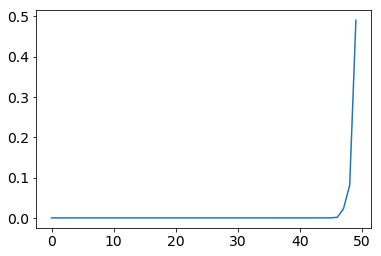

In [16]:
plt.plot(y)

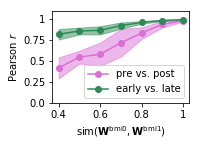

In [40]:

save = True
paper = True


fig,ax = plt.subplots(1,1)
lw = 1
fs = 18

n_samples = np.array(stats['pearson_list']).shape[0]
y = np.mean(np.array(stats['pearson_list']),0)
std = np.std(np.array(stats['pearson_list']),axis=0)
sem = std/np.sqrt(n_samples)
plt.plot(overlaps_w_out0,y,'o-',color='orchid',label='pre vs. post')
plt.fill_between(overlaps_w_out0,y-std,y+std,alpha=0.5,color='orchid')

""" Select for a Specific Task"""

n_samples = np.array(stats['pearson_train_list']).shape[0]
y = np.mean(np.array(stats['pearson_train_list']),0)
std = np.std(np.array(stats['pearson_train_list']),axis=0)
sem = std/np.sqrt(n_samples)
plt.plot(overlaps_w_out0,y,'o-',color='seagreen',label='early vs. late')
plt.fill_between(overlaps_w_out0,y-std,y+std,alpha=0.5,color='seagreen')

plt.ylim([0,1])
plt.ylabel('Pearson ' + r'$r$')
plt.xlabel('sim('+r'$\mathbf{W}^{\mathrm{bmi}0},\mathbf{W}^{\mathrm{bmi}1})$',fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.legend(fontsize=fs)

if paper:
    
    fig,ax = paper_format(fig=fig,ax=ax,xlabels=[0.4,0.6,0.8,1],ylabels=[0.,0.25,0.5,0.75,1],ticksize=10,linewidth=2,ylim=[0,1.1],figsize=(2.25,3))

    
else:
    plt.ylim([0.,1])


plt.tight_layout()
plt.show()


if save:
    if paper:
        fig.savefig(folder+'fig-appendix-covariance-train-Mwbmi1-06-v2.pdf')
    else:
        fig.savefig(folder+'fig-appendix-covariance-train-Mwbmi1-06-v2.pdf')


In [16]:
activity_train[:int(train_duration/2),:,:].shape

# I need to separate into individual tasks

(750, 20, 50)

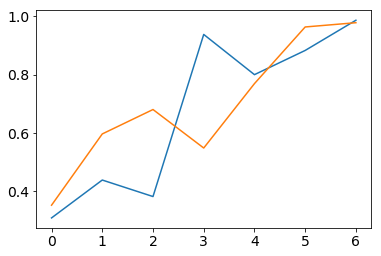

In [38]:
y = np.array(stats['pearson_list'])
plt.plot(y[[0,2],:].T)

In [44]:
task_mn_train_a = np.mean(activity_train[:,:,:],0) # average across half of training trials
cov_a = np.cov(task_mn_train_a.T)
w,_  = np.linalg.eigh(cov_a)
dim_a = np.sum(w)**2 / np.sum(w**2)
print('dim_a: ',dim_a)

dim_a:  1.4382245309312118


## Compare Covariance Matrices pre and post learning

Want it to be trial-averaged

In [8]:
#sim1_pre.session_probes['h']
np.asarray(sim1_post.session_probes['h']).shape

(500, 20, 50, 1)

In [72]:
trackvars = TrackVars(net1_pre,apply_to=[]) 
#sim1_pre.run_session(n_trials=test_duration, tasks=[task1,task2,task3,task4], learn_alg=[trackvars], probe_types=['h','err'], plot=False, plot_freq=10)
sim1_pre.run_session(n_trials=test_duration, tasks=[task1], learn_alg=[trackvars], probe_types=['h','err'], plot=False, plot_freq=10)

trackvars = TrackVars(net1_post,apply_to=[]) 
#sim1_post.run_session(n_trials=test_duration, tasks=[task1,task2,task3,task4], learn_alg=[trackvars], probe_types=['h','err'], plot=False, plot_freq=10)
sim1_post.run_session(n_trials=test_duration, tasks=[task1], learn_alg=[trackvars], probe_types=['h','err'], plot=False, plot_freq=10)


500it [00:05, 97.78it/s]
500it [00:04, 107.88it/s]


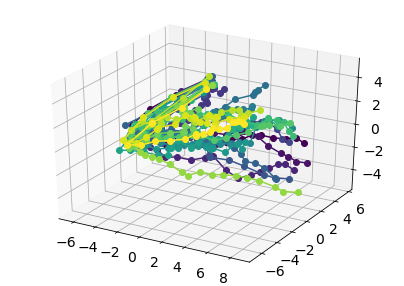

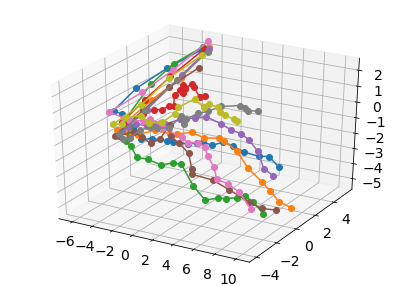

In [8]:
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D

""" Apply PCA """
# concatenate data
activity = sim1_pre.session_probes['h'][0].squeeze()
for i in range(1,len(sim1_pre.session_probes['h'])):
    activity = np.vstack((activity,sim1_pre.session_probes['h'][i].squeeze()))
    

scaler = StandardScaler()
scaler.fit(activity) 
activity_scaled = scaler.transform(activity)
#activity_scaled = activity

pca = PCA(n_components=3)
pca.fit(activity_scaled)
C = pca.components_

activity_pca = pca.transform(activity_scaled) 

Xax = activity_pca[:,0]
Yax = activity_pca[:,1]
Zax = activity_pca[:,2]


fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111, projection='3d')

#ax.scatter(Xax, Yax, Zax,color='C0',alpha=1)
n_trajectories = 20
t_trajectories = np.arange(0,trial_duration*n_trajectories,trial_duration)
colors = interp_colors(n_trajectories,colormap='viridis') 

for n,i in enumerate(t_trajectories):

    ax.plot(Xax[i:i+20], Yax[i:i+20], Zax[i:i+20],'o-',color=colors[n])
    

# fig,ax = plt.subplots(1,1)
# plt.plot(pca.explained_variance_ratio_,'o-')
# plt.ylabel('explained variance')
# plt.xlabel('PC')
# plt.show()

activity_post = sim1_post.session_probes['h'][0].squeeze()
for i in range(1,len(sim1_pre.session_probes['h'])):
    activity_post = np.vstack((activity_post,sim1_post.session_probes['h'][i].squeeze()))
    

activity_post_scaled = scaler.transform(activity_post)
#activity_post_scaled = activity_post

activity_post_pca = pca.transform(activity_post_scaled) 

Xax_post = activity_post_pca[:,0]
Yax_post = activity_post_pca[:,1]
Zax_post = activity_post_pca[:,2]

#ax.scatter(Xax_post, Yax_post, Zax_post,color='C1',alpha=0.1)

fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111, projection='3d')

#ax.scatter(Xax, Yax, Zax,color='C0',alpha=1)

for i in [0,20,40,60,80,100,120,140,160]:

    ax.plot(Xax_post[i:i+20], Yax_post[i:i+20], Zax_post[i:i+20],'o-')


In [ ]:
plt.imshow(cov_pre)

(0.8292895466501065, 0.0)


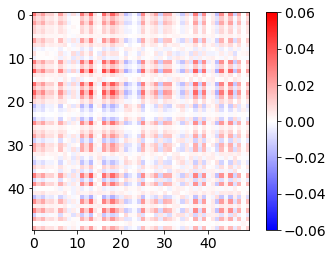

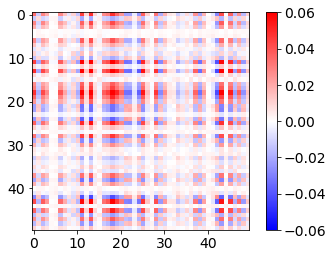

In [5]:
#trial averaged for each neuron!! Need to be careful here.
# do we just want a bar plot? a number?

# COULD ALSO PLOT AS FUNCTION OF WBMI1

from scipy.stats import pearsonr

activity_pre = np.array(sim1_pre.session_probes['h']).squeeze()
task_mn_pre = np.mean(activity_pre,0)

cov_pre = np.cov(task_mn_pre.T)

activity_post = np.array(sim1_post.session_probes['h']).squeeze()
task_mn_post = np.mean(activity_post,0)

cov_post = np.cov(task_mn_post.T)

p_r = pearsonr(cov_pre.ravel(),cov_post.ravel())
print(p_r)

plt.imshow(cov_pre,cmap='bwr',vmin=-0.06,vmax=0.06)
plt.colorbar()
plt.show()

plt.imshow(cov_post,cmap='bwr',vmin=-0.06,vmax=0.06)
plt.colorbar()
plt.show()

In [54]:
cov_pre.shape

(50, 50)

In [56]:
cov_pre.ravel()

array([0.03228716, 0.01447726, 0.02256754, ..., 0.01197966, 0.00075447,
       0.01095019])